In [42]:
!pip install pandas
!pip install geopandas
!pip install lxml
!pip install urllib
!pip install matplotlib
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a
!pip install mapclassify
!pip install folium

ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib


  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to c:\users\auran\appdata\local\temp\pip-req-build-m1jg1xuf
  Resolved https://github.com/inseefrlab/cartiflette to commit 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette 'C:\Users\auran\AppData\Local\Temp\pip-req-build-m1jg1xuf'
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5f9b1a'
  Running command git fetch -q https://github.com/inseefrlab/cartiflette 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Running command git checkout -q 80b8a5a28371feb6df31d55bcc2617948a5f9b1a


   ---------------------------------------- 0.0/97.0 kB ? eta -:--:--
   ---------------------------------------- 97.0/97.0 kB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.3 kB ? eta -:--:--
   ---------------------------------------- 56.3/56.3 kB 2.9 MB/s eta 0:00:00


In [91]:
import importlib
import pandas as pd
import requests
import geopandas as gpd
import declarations_AV as dec
import matplotlib.pyplot as plt
import mapclassify as mc
import folium
from matplotlib import cm
#import os
#from os.path import isfile

Notre travail se décompose en deux études à des échelles différentes. Nous nous sommes d'abord donnés pour but d'étudier la corrélation (et éventuellement la relation de causalité) entre consommation d'électricité du secteur résidentiel et la météo à l'échelle des départements français. En effet, grâce aux données disponibles sur le site d'Enedis, filiale d'EDF chargée de la distribution d'électricité en France, nous pouvons récupérer les données de consommation d'électricté du secteur résidentiel à l'échelle des départements pour les années 2011 à 2021. De plus, nous pouvons récupérer via l'API "<i>Température quotidienne départementale depuis janvier 2018</i>" d'Open Data Réseaux Energie (ODRE) les températures moyennes, minimales et maximales par département. 
La deuxième partie de notre travail sera consacrée, si nous avons le temps, à une régression de la consommation d'électricté sur des variables additionnelles, notamment les Diagnostics de Performance Energétique (DPE), auxquels nous avons uniquement accès par adresse. Nous nous restreindrons alors uniquement aux communes pour lesquelles nous avons aussi pu webscrapper des données météo. 


#### 1- Récupération et analyse descriptive des données de consommation annuelle d'électricité par département et par secteur d'activité

Les données que nous récupérons dans cette partie sont disponibles en Open Data sur le site de l'Agence ORE (Opérateur des Réseaux d'Energie). Plus précisément, le jeu de données que nous utilisons est intitulé "Consommation annuelle d'électricité et gaz par département et par secteur d'activité". Nous ne considérons que la consommation d'électricité du secteur résidentiel. De plus, nous nous restreignons aux départements de France métropolitaine uniquement.

In [4]:
# Base de données provenant du site d'Enedis
df_cons_département=pd.read_csv(dec.cons_département, sep=";")

# Sélection des départements de métropole uniquement
df_cons_département=df_cons_département.loc[~df_cons_département['Code Département'].isin(['971', '972', '973', '974', '975','976'])]

In [5]:
df_cons_département.columns

Index(['Opérateur', 'Année', 'Filière', 'Consommation Agriculture (MWh)',
       'Nombre de points Agriculture',
       'Nombre de mailles secretisées (agriculture)',
       'Indique qualité Agriculture', 'Consommation Industrie (MWh)',
       'Nombre de points Industrie',
       'Nombre de mailles secretisées (industrie)', 'Indice qualité Industrie',
       'Consommation Tertiaire  (MWh)', 'Nombre de points Tertiaire',
       'Nombre de mailles secretisées (tertiaire)', 'Indice qualité Tertiaire',
       'Consommation Résidentiel  (MWh)', 'Nombre de points Résidentiel',
       'Nombre de mailles secretisées (résidentiel)',
       'Indice qualité Résidentiel', 'Consommation Secteur Inconnu (MWh)',
       'Nombre de points Secteur Inconnu',
       'Nombre de mailles secretisées (secteur inconnu)',
       'Indice qualité Non Affecté', 'Code Département', 'Libellé Département',
       'Code Région', 'Libellé Région', 'id_filiere', 'geom',
       'Consommation totale (MWh)'],
      dtype='

In [6]:
# Sélection des variables auxquelles nous nous intéressons
variables_cons_département= ['Opérateur', 'Année', 'Filière', 
                             'Consommation Résidentiel  (MWh)', 'Nombre de points Résidentiel', 
                             'Nombre de mailles secretisées (résidentiel)','Indice qualité Résidentiel',
                             'Code Département', 'Libellé Département','Code Région', 'Libellé Région', 
                             'id_filiere','Consommation totale (MWh)']
liste_département=pd.unique(df_cons_département["Libellé Département"])

In [10]:
list_années=pd.unique(df_cons_département["Année"])
# Dictionnaire qui à chaque année associe le dataframe de consommation d'électricité 
# résidentielle par départements :
dico_cons_département={} 
# Dictionnaire qui à chaque année associe le dataframe contenant uniquement : 
# consommation totale d'électricité et code département :
dico_df_cons_tot={}
# Dictionnaire qui à chaque année associe la valeur de la consommation totale d'électricité du secteur
# résidentiel en France : 
dico_cons_tot={} 
for année in list_années:
    if année not in dico_cons_département.keys():
        df_année=dec.get_data_consumption_department(df_cons_département, année)
        dico_cons_département[année]=dec.df_filter(df_année, variables_cons_département) # On sélectionne les variables dont on a besoin
        df_cons_tot=dico_cons_département[année].groupby(["Code Département","Libellé Département"])['Consommation Résidentiel  (MWh)'].sum().reset_index()
        #df_cons_tot["Legende"] = [f"{ligne['Libellé Département']} : {ligne['Consommation Résidentiel  (MWh)']} MWh" \
                             #for _, ligne in df_cons_tot.iterrows()]
        dico_df_cons_tot[année]=df_cons_tot
        dico_cons_tot[année]=df_cons_tot['Consommation Résidentiel  (MWh)'].sum()


Premier aperçu de la base de données après sélection des variables d'intérêt : 

In [11]:
dico_cons_département[2018].head(3)

,Opérateur,Année,Filière,Consommation Résidentiel (MWh),Nombre de points Résidentiel,Nombre de mailles secretisées (résidentiel),Indice qualité Résidentiel,Code Département,Libellé Département,Code Région,Libellé Région,id_filiere,Consommation totale (MWh)
1167,EdF-SEI,2018,Electricité,5.086647e+05,101593,0,0.000,2A,Corse-du-Sud,94,Corse,100,9.922387e+05
1170,Enedis,2018,Electricité,1.173655e+06,233222,6,0.471,02,Aisne,32,Hauts-de-France,100,2.765229e+06
1171,Enedis,2018,Electricité,8.839105e+05,192441,5,0.606,03,Allier,84,Auvergne-Rhône-Alpes,100,2.008387e+06


In [12]:
dico_df_cons_tot[2018].head(3)

,Code Département,Libellé Département,Consommation Résidentiel (MWh)
0,01,Ain,1.743025e+06
1,02,Aisne,1.300874e+06
2,03,Allier,8.839105e+05


In [92]:
# Création d'un GeoDataFrame des départements français
departements=dec.df_filter(dec.dep, dec.var_dep)
departements=gpd.GeoDataFrame(departements, geometry=departements['geometry'])
departements_json=departements.to_json()

In [70]:
dico_carte={}
for annee in list_années:
    dico_carte[annee]=gpd.GeoDataFrame(dico_df_cons_tot[annee].merge(departements, left_on='Code Département',
                                                    right_on='INSEE_DEP', how='left'))
    dico_carte[annee].drop('INSEE_DEP', axis='columns')
    dico_carte[annee]['Consommation Résidentiel  (MWh)']=dico_carte[annee]['Consommation Résidentiel  (MWh)'].round()

q5=mc.Quantiles(dico_carte[2018]['Consommation Résidentiel  (MWh)'], k=5)

mapping=dict([(i, s) for i, s in enumerate(q5.get_legend_classes())])

# Fonction permettant de remplacer les chiffres de la légende par les valeurs des intervalles
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


C:\Users\auran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


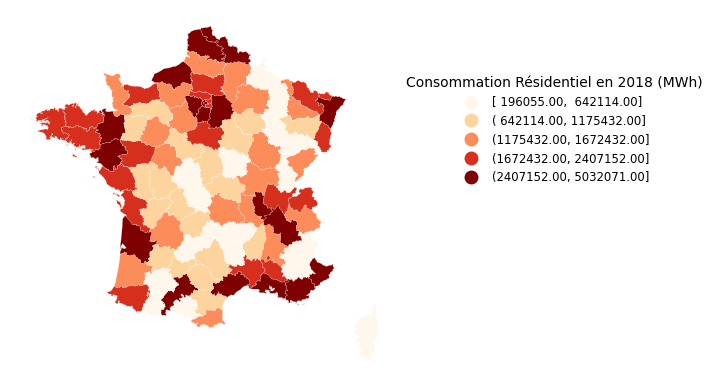

In [89]:
# On trace la carte 
ax = dico_carte[2018].plot(
    column=q5.yb,
    categorical=True,
    k=5,
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    legend_kwds=dict(loc='lower left',
                            bbox_to_anchor=(1, .5),
                            fontsize='small',
                            title="Consommation Résidentiel en 2018 (MWh)",
                            frameon=False),
)
ax.set_axis_off()
replace_legend_items(ax.get_legend(), mapping)

On représente à présent l'évolution de la consommation d'énergie du résidentiel entre 2011 et 2021 :

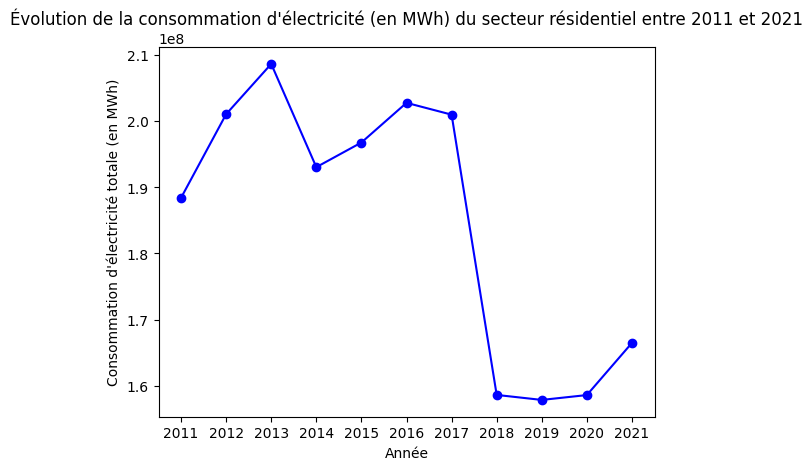

In [12]:
conso_par_an=list(dico_cons_tot.values())
plt.plot(list_années, conso_par_an, marker='o', linestyle='-', color='b')
plt.title("Évolution de la consommation d'électricité (en MWh) du secteur résidentiel entre 2011 et 2021")
plt.xlabel('Année')
plt.ylabel("Consommation d'électricité totale (en MWh)")
plt.xticks(list_années)
plt.show()

### 2- Récupération des données de températures annuelles à l'échelle des départements

Il s'agit à présent de récupérer les températures moyennes annuelles par département pour au moins l'une des années pour lesquelles nous avons des données de consommation. Pour cela nous avons trouvé le jeu de données disponible en Open Data sur le site de l'ODRE, donnant les températures quotidiennes départementales depuis janvier 2018.\
La manière la plus efficace d'obtenir des températures moyennes annuelles (et minimales et maximales puisqu'elles sont aussi à disposition) par département est d'utiliser l'API en effectuant directement la requête adaptée. Dans le cas des températures moyennes, on utilise `group_by(code_insee_departement)` avec `select(avg(tmoy))`.

In [9]:
# Création d'un dictionnaire qui à chaque année associe un dataframe contenant la température moyenne,
# la température minimale et la température maximale enregistrées par département
dico_df_temp={}
for année in [2018,2019,2020,2021]:
    if année not in dico_df_temp.keys():
        df_tmoy=dec.get_data_from_api(dec.api_root_temp, dec.api_req_tmoy, année)
        df_tmin=dec.get_data_from_api(dec.api_root_temp, dec.api_req_tmin, année)
        df_tmax=dec.get_data_from_api(dec.api_root_temp, dec.api_req_tmax, année)
        res=df_tmax.merge(df_tmin, on='code_insee_departement',how='left')
        df_temp=df_tmoy.merge(res, on='code_insee_departement', how='left')
        df_temp.rename(columns={'avg(tmoy)':'tmoy', 'max(tmax)':'tmax', 'min(tmin)':'tmin'}, inplace=True)
        #df_temp['Legende']=[f'{ligne.Région} : {ligne.Ensoleillement}kWh/m²' \
                             #for _, ligne in ensoleillement.iterrows()]
        dico_df_temp[année]=df_temp

In [10]:
dico_df_temp[2018].head(3)

,code_insee_departement,tmoy,tmax,tmin
0,01,13.337260,36.9,-12.1
1,02,11.747260,36.2,-9.5
2,03,13.007123,38.0,-12.8


In [22]:
# Carte des températures moyennes
center_latitude = departements['geometry'].centroid.y.mean()
center_longitude = departements['geometry'].centroid.x.mean()

m = folium.Map(location=[center_latitude, center_longitude], zoom_start=5, tiles='cartodbpositron')

choropleth_temp=folium.Choropleth(geo_data=departements_json,
    data=dico_df_temp[2018],
    columns=['code_insee_departement','tmoy'],
    fill_color="OrRd",  # Colormap
    key_on='feature.properties.INSEE_DEP',
    fill_opacity=0.7,
    legend_name='Température moyenne (°C)',  # Nom de la légende
    highlight=True,
    nan_fill_color='blue',  # Couleur pour les valeurs manquantes
)
#choropleth_temp.add_to(m_temp)
#m_temp.save("cartes\carte_temperatures.html")

### Création d'un dataframe alliant données de consommation et données météo
On choisit en particulier de s'intéresser au cas de l'année 2021

In [12]:
df_2021=dico_df_cons_tot[2021].merge(dico_df_temp[2021], how='left', left_on='Code Département', right_on='code_insee_departement')
df_2021.head(3)

,Code Département,Libellé Département,Consommation Résidentiel (MWh),Legende,code_insee_departement,tmoy,tmax,tmin
0,01,Ain,1.862766e+06,Ain : 1862765.9818485 MWh,01,11.262192,33.2,-10.3
1,02,Aisne,1.364467e+06,Aisne : 1364467.03377802 MWh,02,10.729589,30.3,-7.8
2,03,Allier,9.465712e+05,Allier : 946571.2309897 MWh,03,11.470959,34.5,-8.7


### 4- Téléchargement des données de consommation d'électricité annuelle par adresse

In [ ]:
df_cons_2018=get_data_consumption(dec.consumption_data_url_2018, "2018")
df_cons_2019=get_data_consumption(dec.consumption_data_url_2019, "2019")
df_cons_2020=get_data_consumption(dec.consumption_data_url_2020, "2020")
df_cons_2021=get_data_consumption(dec.consumption_data_url_2021, "2021")

### 5- Récupération des données de Diagnostics de Performance Energétique (DPE)

In [ ]:
def get_dpe_from_url(api_url):
    '''Imports a database from an API url.
    Args:
        api_url (string) : url of the wanted API
    Returns:
        pandas.DataFrame : dataframe
    '''
    req=requests.get(api_url)
    wb=req.json()
    df = pd.json_normalize(wb["results"])
    dpe = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = 4326)
    dpe = dpe.dropna(subset = ['longitude', 'latitude'])
    return dpe

In [ ]:
# Il est trop couteux de récupérer l'intégralité des données et nous ne disposons de données météo que pour
# certaines communes. L'idée est donc de ne récupérer les données de DPE que pour les communes voulues et de
# les agréger dans une unique table de données.

def get_dpe_dataset(api_root, communes):
    '''
    Args : 
    Returns : 
    '''